# PhenoGraph Pipeline
# 3/4 Gene Expression Signature Define by Silico Expression Deconvolution
This part tries to link GEO arrays to single cell data. 

For each score, %SDPC or %IFPC, a set of associated genes was defined based on correlation with the expression patterns across the patients. This method, known as in silico gene expression deconvolution (Lu et al., 2003; Stuart et al., 2004), assumes that a subpopulation of interest will express certain genes at constant rates; therefore, changes in bulk expression will track with changes in subpopulation size. This can be formalized as a linear regression problem:

$Y=X\beta + \epsilon$

in which Y is a N x G matrix of G mean-centered gene expression values, X is a N x 1 vector of the patient feature (e.g., %IFPC), and 𝛽 is a 1 x G vector of regression coefficients. 𝛽 can be obtained from the least squares solution and represents, for each gene, the strength of its
association with the patient feature.

$\beta = (X^T X)^{-1}X^T Y$

## GEO data set preprocess:


In [67]:
import pandas as pd
import numpy as np
import math
from itertools import *
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
# load SDPC IFPC and Affymetrix
samples = pd.read_csv("sample_information.csv",index_col=0)
probe_e = pd.read_csv("GEO/GSE14471_series_matrix.csv",index_col=0,header=68)
gene_knowledge = pd.read_csv("geneknowledge.csv",index_col=0)

In [69]:
probe_e.shape

(22284, 111)

In [70]:
gene_knowledge.shape

(22283, 15)

In [71]:
probe_e = probe_e.drop( probe_e.index[pd.isnull(probe_e).sum(axis=1) >= 1] )

In [72]:
probe_e = np.log2(probe_e.loc[:,:])
probe_e = probe_e.T
normalizer = probe_e.quantile(0.75)

print("There are {} probes in GEO; ID # GSE14471".format(probe_e.shape[1]))
probe_e = probe_e.loc[samples['GEO ID '],:]

There are 22283 probes in GEO; ID # GSE14471


In [73]:
excluded_probes_1 = []
for c in probe_e.columns:
    if (sum(probe_e[c]<7) >= 12) or (probe_e[c].std() <0.25):
        excluded_probes_1.append(c)
print("{} probes were removed for low intensity (defined as being below 7 on log2 scale in at least 12 of the 16 arrays)".format(len(excluded_probes_1)))


6950 probes were removed for low intensity (defined as being below 7 on log2 scale in at least 12 of the 16 arrays)


In [78]:
samples = samples.drop("SJ12")
# probe_e = probe_e.T
# probe_e = (probe_e.loc[:,samples['GEO ID ']])
# probe_e = probe_e.T
probe_e = probe_e.ix[samples['GEO ID ']]

c = probe_e.loc[:,np.logical_not(probe_e.columns.isin(excluded_probes_1))]
# probe_e = probe_e/normalizer
probe_e = probe_e/probe_e.quantile(0.75)

In [79]:
# average probes targeting for a same gene
tagret_genes = []

gene_knowledge = gene_knowledge.ix[probe_e.columns.values]

for c in probe_e.columns.values:
    tagret_genes.append(gene_knowledge.loc[c,['Gene Symbol']].values[0])
tagret_genes = np.array(tagret_genes)

unique_target_probes = []
unique_genes = []
tagret_genes_split = []

for i,t in enumerate(tagret_genes):
    if type(t[0]) == str:
        tagret_genes_split.append(t.split("///"))    

#  creat a mapping dictionary
genes_to_probes={}

for i,gs in enumerate(tagret_genes_split):
    for g in gs:
        genes_to_probes[str.strip(g)] = []
            
for i,gs in enumerate(tagret_genes_split):
    for g in gs:
        genes_to_probes[str.strip(g)].append(gene_knowledge.index[i])
    
del genes_to_probes["nan"]

In [80]:
count = 0 
exclueded_genes = []
gene_expression = pd.DataFrame([],index=probe_e.index)
for gene in genes_to_probes:
    # if there are more than 1 probe target this gene
    if len(genes_to_probes[gene]) > 1: 

        # finding the correlation matrix of probes
        r = np.corrcoef(probe_e[genes_to_probes[gene]],rowvar=0)
#         for i in range(r.shape[0]):
#             for j in range(r.shape[1]):
#                 if i==j:
#                     r[i,j] = 1
        s = r > 0.75
        
        if np.sum(s.flatten()) == 0:
            exclueded_genes.append(gene)
#           no edge
            continue
        
        G = nx.from_numpy_matrix(s)
        generator = nx.find_cliques(G)
        
        memberlist = [c for c in generator]
#        if none in this subset is correlated to each other, skip


#       max clique menber indexes
        ixx = np.argmax([len(l) for l in memberlist])
        subset = memberlist[ixx]
        
        if len(subset) <= 1:
#            all cliques has itself as the only member
           gene_expression[gene] = probe_e[genes_to_probes[gene][0]]
#             exclueded_genes.append(gene)
#             continue
        else:
            t = np.array(genes_to_probes[gene])
            t = t[subset]
            gene_expression[gene] = probe_e[t].mean(axis=1)
            count = count + 1

    else:
        gene_expression[gene] = probe_e[genes_to_probes[gene]]
        count = count + 1
print("Probe sets targeting the same gene whose measurementswere well correlated (r > .75) were averaged to produce consensus expression values for {} unique genes.".format(count) )
#gene_expression.iloc[:,:] = gene_expression.iloc[:,:]
print("{} Genes were excluded for they are targeted by several uncorrelated probes".format(len(exclueded_genes)) )
     
# gene_expression.to_csv("sorted_gene_expression.csv") 


Probe sets targeting the same gene whose measurementswere well correlated (r > .75) were averaged to produce consensus expression values for 9872 unique genes.
0 Genes were excluded for they are targeted by several uncorrelated probes


In [81]:
tttt= gene_expression

In [83]:
# center each gene 
from scipy.stats import zscore
gene_expression = tttt
# gene_expression = gene_expression

l = len(gene_expression.index)
b = np.zeros((int(l*(l-1)/2),gene_expression.shape[1]))
# leave-two-out cross validation
for i,c in enumerate(combinations(gene_expression.index,2)):
    Y = gene_expression.ix[np.logical_not(gene_expression.index.isin([c[0],c[1]]))].values    
#    X = samples.loc[np.logical_not(gene_expression.index.isin([c[0],c[1]])),['SDPC Freq. (%)',"IFPC Freq. (%)"]].values
    X = samples.loc[np.logical_not(gene_expression.index.isin([c[0],c[1]])),["IFPC Freq. (%)"]].values
    b[i,:] = (np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y))
#     b[i,:] = 

In [84]:
std_b = 0.05 
std = np.std(gene_expression,axis=0)
mean = np.mean(gene_expression,axis=0)
stat = []

# for every b
a = np.zeros(b.shape)
# put every gene to its percentile bins
for j in range(b.shape[0]):
    a[j,:] = np.argsort(b[j,:]) / b.shape[1]
# count the times one gene is in top 1% and otherwise in 105 test
for i in range(b.shape[1]):
    xedges = np.linspace(0,1,200)
    hist, _ = np.histogram(a[:,i].flatten(),xedges)
    stat.append( ( sum( hist[:-1] > hist[-1]) == 0) 
                    and (std[i]/mean[i] <= std_b  ) )
#     stat.append(sum(a[:,i]>prc_b) > sum(a[:,i]<=prc_b)) and (std[i]/mean[i] <= std_b) 
stat = np.array(stat)
signature = np.sort(gene_expression.columns.values[stat])
print("IFPC% Signature contains {} genes".format(len(signature)))    

signature = signature.astype("str")
print(np.sort(signature))

ref_sig = pd.read_csv("signature.csv")
intersect = np.intersect1d(ref_sig["IFPC"].values,signature)
print("There are {} genes same as what is found in original works:{}".format(len(intersect),intersect))

IFPC% Signature contains 30 genes
['ANXA8' 'ASB1' 'ASF1B' 'BANP' 'C2orf47' 'FARS2' 'G3BP1' 'HOXC4' 'LHX3'
 'MIR1236' 'MKNK1' 'MUC3A' 'MUS81' 'MYL12B' 'NDUFA4' 'NPM3' 'P2RX6'
 'PAFAH2' 'PMS1' 'PSMC1' 'RHOQ' 'RP4-595K12.1' 'SLC12A6' 'SMARCD2' 'STARD7'
 'TP53TG3D' 'TPT1' 'TUBA3C' 'VRK1' 'WDR59']
There are 0 genes same as what is found in original works:[]


In [85]:
np.sort(ref_sig["IFPC"].values)

array(['ADA', 'AKR1C3', 'ANKRD28', 'ATF3', 'ATP1B1', 'CD96', 'CLDN6',
       'CLIP2', 'CLMN', 'CLN6', 'CPA3', 'CST7', 'CTNNBIP1', 'DDIT4',
       'DNMT3B', 'DUSP10', 'ENPP2', 'ENTPD6', 'FCHO1', 'FOCAD', 'FOSB',
       'GLS', 'GNA15', 'GPHN', 'GPR125', 'IGFBP2', 'IL8', 'ITPR2', 'KCNJ8',
       'LENEP', 'LHX6', 'LZTFL1', 'MEGF6', 'MEX3C', 'NFIL3', 'NR4A2',
       'PLXNC1', 'PROM1', 'PTGS2', 'RRAGD', 'RUFY3', 'SEMA6D', 'SIK1',
       'SLC2A5', 'SMAD1', 'SOCS2', 'SPINK2', 'TPBG', 'ZSCAN5A'], dtype=object)

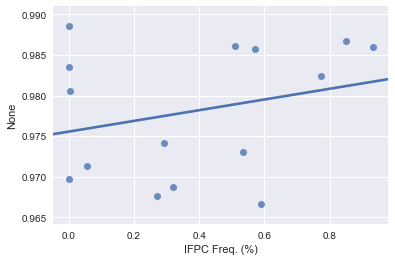

In [86]:
ax = sns.regplot(x=samples["IFPC Freq. (%)"], y=gene_expression[signature].mean(axis=1), ci=None)

In [64]:
# center each gene 
# gene_expression = gene_expression - gene_expression.mean()

l = len(gene_expression.index)
b = np.zeros((int(l*(l-1)/2),gene_expression.shape[1]))
# leave-two-out cross validation
for i,c in enumerate(combinations(gene_expression.index,2)):
    Y = gene_expression.ix[np.logical_not(gene_expression.index.isin([c[0],c[1]]))].values    
#    X = samples.loc[np.logical_not(gene_expression.index.isin([c[0],c[1]])),['SDPC Freq. (%)',"IFPC Freq. (%)"]].values
    X = samples.loc[np.logical_not(gene_expression.index.isin([c[0],c[1]])),["SDPC Freq. (%)"]].values
    b[i,:] = (np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y))

In [65]:
std_b = 0.05 
std = np.std(gene_expression,axis=0)
mean = np.mean(gene_expression,axis=0)
stat = []

# for every b
a = np.zeros(b.shape)
# put every gene to its percentile bins
for j in range(b.shape[0]):
    a[j,:] = np.argsort(b[j,:]) / b.shape[1]
# count the times one gene is in top 1% and otherwise in 105 test
for i in range(b.shape[1]):
    xedges = np.linspace(0,1,100)
    hist, _ = np.histogram(a[:,i].flatten(),xedges)
    stat.append( ( sum( hist[:-1] > hist[-1]) == 0) 
                    and (std[i] <= std_b  ) )
#     stat.append(sum(a[:,i]>prc_b) > sum(a[:,i]<=prc_b)) and (std[i]/mean[i] <= std_b) 
stat = np.array(stat)
signature = np.sort(gene_expression.columns.values[stat])
print("SDPC% Signature contains {} genes".format(len(signature)))    

signature = signature.astype("str")
print(np.sort(signature))

ref_sig = pd.read_csv("signature.csv")

intersect = np.intersect1d(ref_sig["SDPC"][np.logical_not(pd.isnull(ref_sig["SDPC"]))],signature)
print("There are {} genes same as what is found in original works:{}".format(len(intersect),intersect))

SDPC% Signature contains 52 genes
['ABCD1' 'ACAD8' 'AGT' 'ANXA1' 'AP5S1' 'BTK' 'CNDP2' 'CNOT6' 'CPED1' 'CRBN'
 'EFTUD1' 'GABARAPL2' 'GALNT6' 'GATC' 'GBF1' 'GGA1' 'GGT1' 'GNG5' 'KRT2'
 'MAPK6' 'MEN1' 'MLH1' 'NDUFA9' 'NGRN' 'ORAI3' 'PGLYRP4' 'PJA2' 'POMP'
 'PSMC1' 'PTGES3L-AARSD1' 'PTP4A1' 'RFXANK' 'RPLP0' 'RPS12' 'SARAF'
 'SCAMP3' 'SCNM1' 'SEC24B' 'SERP1' 'SF3B4' 'SLC43A3' 'SNORD23' 'SNORD38B'
 'SRRT' 'TGDS' 'THOC1' 'TMEM120B' 'TNPO1' 'TSPYL4' 'VAPA' 'ZNF816-ZNF321P'
 'ZNHIT3']
There are 0 genes same as what is found in original works:[]


In [26]:
np.sort(ref_sig["SDPC"][np.logical_not(pd.isnull(ref_sig["SDPC"]))])

array(['AGTPBP1', 'ANPEP', 'APOL2', 'BAALC', 'CD200', 'CD34', 'CLEC2B',
       'CLIC4', 'DAGLA', 'DAPK1', 'DEPTOR', 'DHRS3', 'EGFL7', 'EHD3',
       'FCGRT', 'FLNB', 'GAB2', 'GATM', 'GIT2', 'HGF', 'HIST1H2BH',
       'ITM2C', 'MAN1A1', 'MDFIC', 'MIR4448', 'MN1', 'MRC1', 'NARFL',
       'NCAPH2', 'NRXN2', 'PELI2', 'PMAIP1', 'PMP22', 'PTGER4', 'PTOV1',
       'SEC31B', 'SEPT9', 'SIDT1', 'TGFB1I1', 'WASF1', 'XPA', 'ZCCHC14'], dtype=object)

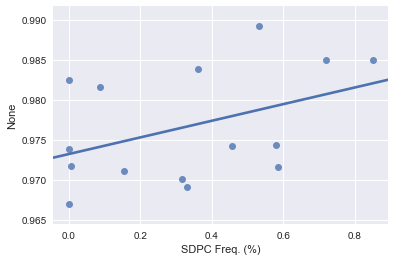

In [66]:
ax = sns.regplot(x=samples["SDPC Freq. (%)"], y=gene_expression[signature].mean(axis=1), ci=None)

/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


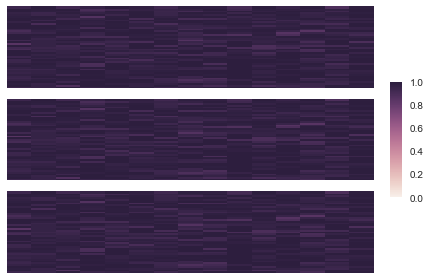

In [153]:
t = gene_expression[signature].T

fig, axn = plt.subplots(3, 1, sharex=True, sharey=False)

cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, ax in enumerate(axn.flat):
    sns.heatmap(t, ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                xticklabels=False,yticklabels=False,
                cbar_ax=None if i else cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])

# ax = sns.heatmap(t,cbar=False,xticklabels=False,yticklabels=False,cmap="YlGnBu")
